# Explaining Final Model Predictions

In this notebook, I will use [LIME library](https://github.com/marcotcr/lime) to interpret test data predictions of my final CNN model to understand the reasoning behind some of the predictions and judge the reliability of the model. While there are 1138 images are predicted correctly by the final model, 106 skin lesion images are predicted incorrectly. Let's took into the LIME explanations and understand how some of those predictions are made by the final CNN model.

In [1]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
from numpy import loadtxt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Explainable AI library
from lime import lime_image
from skimage.segmentation import mark_boundaries

## 1. Data Understanding 

In [2]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET_512x512.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12431,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12432,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12433,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12434,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg


In [3]:
df['benign_malignant'].value_counts()


benign       6750
malignant    5686
Name: benign_malignant, dtype: int64

In [4]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [5]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       4845
malignant    4108
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
2034,ISIC_0714807,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,20.0,upper extremity,benign
6216,ISIC_1984995,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,30.0,palms/soles,benign
1848,ISIC_0663588,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,torso,benign
11624,ISIC_0071693,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,40.0,head/neck,malignant
4775,ISIC_1558731,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,torso,benign
...,...,...,...,...,...,...
2578,ISIC_0884397,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,torso,benign
11825,ISIC_0072990,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,anterior torso,malignant
672,ISIC_0307958,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,palms/soles,benign
6213,ISIC_1984152,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign


In [8]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Validation dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Validation dataset: 
 benign       1211
malignant    1028
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
8227,ISIC_0028219,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,45.0,upper extremity,malignant
3879,ISIC_1289942,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,torso,benign
2819,ISIC_0954236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
11196,ISIC_0068438,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,75.0,palms/soles,malignant
1808,ISIC_0652205,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,lower extremity,benign
...,...,...,...,...,...,...
10278,ISIC_0062029,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,80.0,anterior torso,malignant
5484,ISIC_1768051,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,70.0,lower extremity,benign
4342,ISIC_1431236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign
3993,ISIC_1326366,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,lower extremity,benign


In [9]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       694
malignant    550
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10405,ISIC_0062914,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,lower extremity,malignant
6392,ISIC_2038024,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
1483,ISIC_0552960,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,lower extremity,benign
4190,ISIC_1384527,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,lower extremity,benign
8635,ISIC_0032724,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,posterior torso,malignant
...,...,...,...,...,...,...
8450,ISIC_0030929,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,55.0,upper extremity,malignant
4949,ISIC_1611285,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,30.0,lower extremity,benign
2239,ISIC_0772957,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
10402,ISIC_0062891,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,35.0,anterior torso,malignant


## 2. Image Preprocessing

In [10]:
# Instantiating a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Creating the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_train),
                                                seed=42,
                                                class_mode='binary')


# Creating the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 64x64
                                              target_size=(64, 64),
                                              batch_size=len(df_val),
                                              seed=42,
                                              class_mode='binary')


# Setting aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_test),
                                                seed=42,
                                                class_mode='binary')

Found 8953 validated image filenames belonging to 2 classes.
Found 2239 validated image filenames belonging to 2 classes.
Found 1244 validated image filenames belonging to 2 classes.


In [11]:
# Create image and labels data sets by using next() fnc:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [12]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


## 3. Final CNN Model

In [13]:
# Load the final model:
final_model = load_model('../Saved_Models/cnn4_model.h5')

In [14]:
# Evaluate the test/holdout set:
final_score = final_model.evaluate(test_images, test_labels)

39/39 [==============================] - 1s 24ms/step - loss: 0.5627 - accuracy: 0.9148 - recall: 0.9055 - precision: 0.9022 - auc: 0.9664


In [15]:
# Final model accuracy and recall socre on test set:
print("%s: %.2f%%" % (final_model.metrics_names[1], final_score[1]*100))
print("%s: %.2f%%" % (final_model.metrics_names[2][:-2], final_score[2]*100))

accuracy: 91.48%
reca: 90.55%


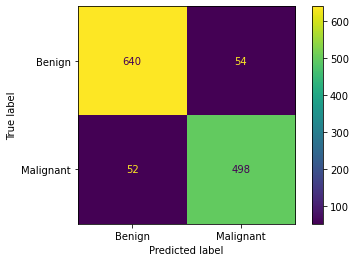

In [16]:
# Plot confusion matrix to see how many images are predicted corretly and incorrectly:
test_preds = (final_model.predict(test_images) > 0.5).astype("int32")
test_cm = confusion_matrix(test_labels, test_preds)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Benign', 'Malignant'])
test_disp.plot()
plt.show()

While 1138 images are labelled correctly with the final model, 106 images are labelled incorrectly. Now, let's look into the reasoning behind some of correctly labelled and uncorrtectly labelled predictions by using [LIME library](https://github.com/marcotcr/lime).

## 4. Exploring Final Model Predictions

In [17]:
# Put correctly and incorrectly predicted images in separate lists: 
corrects = []
incorrects= []
for i in range(len(test_images)):
    if test_preds[i] == test_labels[i]:
        corrects.append(i)
    else:
        incorrects.append(i)

### 4.1 Incorrectly Labelled Image Explanation

#### Malignant Lesion with Incorrect Prediction:

True label: 1.0
Predicted label: [0]


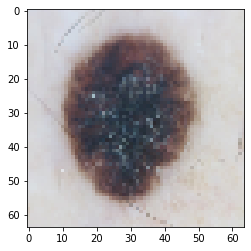

In [18]:
# Look at the first incorrectly labeled image:
idx=0
img = train_images[incorrects[idx]]
plt.imshow(img);

print(f'True label: {test_labels[incorrects[idx]]}')  
print(f'Predicted label: {test_preds[incorrects[idx]]}')

In [19]:
# Instantiate the Lime Image Explainer(): 
explainer = lime_image.LimeImageExplainer()

# Fit on the explainer by specifying the image and final_model:
explanation = explainer.explain_instance(train_images[incorrects[idx]].astype('double'), 
                                         final_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

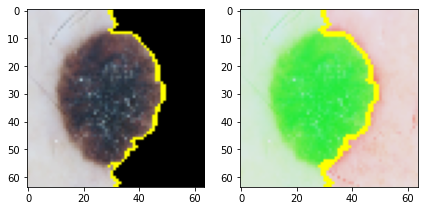

In [20]:
# Visualize the explanation:
temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(mark_boundaries(temp1, mask1))
ax2.imshow(mark_boundaries(temp2, mask2));

**Analysis:** This lesion is malignant but predicted to be benign by the model. There is not much extra disturbances on the image, but model focuses on both the lesion and the hair on one side of the image and prediction becomes wrong. 

#### Benign Lesion with Incorrect Prediction:

True label: 0.0
Predicted label: [1]


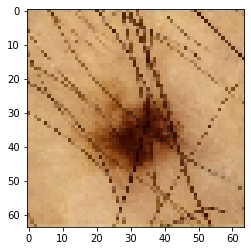

In [21]:
# Let's look at another incorrectly labeled image:
idx=9
img = train_images[incorrects[idx]]
plt.imshow(img);

print(f'True label: {test_labels[incorrects[idx]]}')  
print(f'Predicted label: {test_preds[incorrects[idx]]}')

In [22]:
# Instantiate the Lime Image Explainer(): 
explainer = lime_image.LimeImageExplainer()

# Fit on the explainer by specifying the image and final_model:
explanation = explainer.explain_instance(train_images[incorrects[idx]].astype('double'), 
                                         final_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

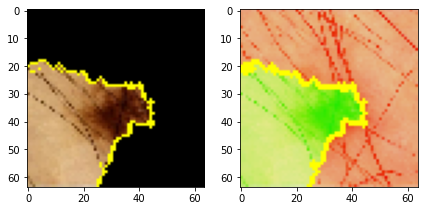

In [23]:
# Visualize the explanation:
temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(mark_boundaries(temp1, mask1))
ax2.imshow(mark_boundaries(temp2, mask2));

**Analysis:** This lesion is benign but predicted to be malignant by the model. There is so much extra disturbances on the image, even if model does not focus on much of those disturbances, it still classifies the image wrong because it cannot focus only on the lesion itself. 

### 4.2 Correctly Labelled Image Explanation

#### Benign Lesion with Correct Prediction: 

True label: 0.0
Predicted label: [0]


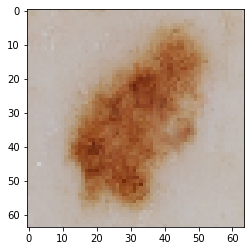

In [24]:
# Look at one correctly labeled image:
idx=50
img = train_images[corrects[idx]]
plt.imshow(img);

print(f'True label: {test_labels[corrects[idx]]}')  
print(f'Predicted label: {test_preds[corrects[idx]]}')

In [25]:
# Instantiate the Lime Image Explainer(): 
explainer = lime_image.LimeImageExplainer()

# Fit on the explainer by specifying the image and final_model:
explanation = explainer.explain_instance(train_images[corrects[idx]].astype('double'), 
                                         final_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

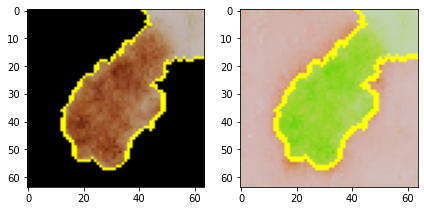

In [26]:
# Visualize the explanation:
temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(mark_boundaries(temp1, mask1))
ax2.imshow(mark_boundaries(temp2, mask2));

**Analysis:** The model focusses mostly on the lesion itself and highlights the lesion boundary for this image, and predicts its class correctly. The picture itself is clean, there is no marker, ruler, or hair on the image.

#### Malignant Lesion with Correct Prediction:

True label: 1.0
Predicted label: [1]


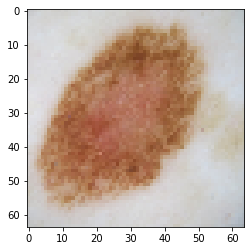

In [27]:
# Look at one correctly labeled image:
idx=98
img = train_images[corrects[idx]]
plt.imshow(img);

print(f'True label: {test_labels[corrects[idx]]}')  
print(f'Predicted label: {test_preds[corrects[idx]]}')

In [28]:
# Instantiate the Lime Image Explainer(): 
explainer = lime_image.LimeImageExplainer()

# Fit on the explainer by specifying the image and final_model:
explanation = explainer.explain_instance(train_images[corrects[idx]].astype('double'), 
                                         final_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

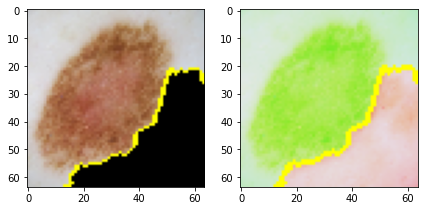

In [29]:
# Visualize the explanation:
temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(mark_boundaries(temp1, mask1))
ax2.imshow(mark_boundaries(temp2, mask2));

**Analysis:** The model look at the lesion itself and highlights the lesion boundary for this image, and predicts its class correctly. The picture itself is clean, only shows the lesion as well.

True label: 1.0
Predicted label: [1]


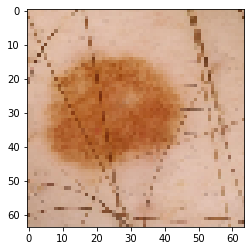

In [30]:
# Look at another correctly labeled image:
idx=104
img = train_images[corrects[idx]]
plt.imshow(img);

print(f'True label: {test_labels[corrects[idx]]}')  
print(f'Predicted label: {test_preds[corrects[idx]]}')

In [31]:
# Instantiate the Lime Image Explainer(): 
explainer = lime_image.LimeImageExplainer()

# Fit on the explainer by specifying the image and final_model:
explanation = explainer.explain_instance(train_images[corrects[idx]].astype('double'), 
                                         final_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

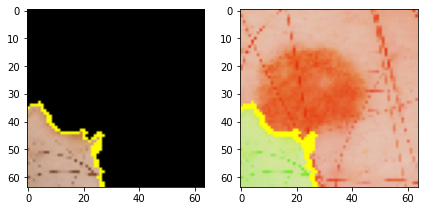

In [32]:
# Visualize the explanation:

# Left image shows only where the model focusses on and hides the rest:
temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Right image highlights image parts with green where it has pros for the prediction 
# and highlights image parts with red color where it has cons for the prediction:
temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(mark_boundaries(temp1, mask1))
ax2.imshow(mark_boundaries(temp2, mask2));

**Analysis:** Even if model predicts the class of this image correctly, when we look at the explaination behind this prediction, it is seen that the model does not focus on the lesion, but the hair on the image. This explanation shows us the importance of image cleaning to get more reliable predictions.

## 5.Conclusion

The model predicts the class correctly if the skin lesion image does not have any extra disturbances, such as marker, ruler, or hair. Clean image usage is very important for the final model predictions to get the reliable predictions. As a next step, I would like to retrain CNN model with clean dermoscopic images to both improve the accuracy and reliability of the model. 